In [635]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

Simple logistic regression

In [655]:
data = pd.read_csv('data/ML_DATA_MXF.csv')
data.dropna(inplace= True)

#remove line below to train on samples rather than mutations
data.drop_duplicates(subset=['GENE_MUTATION'], keep='first', inplace=True)
data.GENE_MUTATION.value_counts()

GENE_MUTATION
gyrA_D94G     1
gyrA_A322E    1
gyrA_H334Y    1
gyrB_K452N    1
gyrB_G598E    1
             ..
gyrA_T267I    1
gyrB_D461N    1
gyrA_S237P    1
gyrB_S576T    1
gyrB_G594R    1
Name: count, Length: 145, dtype: int64

In [656]:
data.CLEAN_BINARY_PHENOTYPE.value_counts()

CLEAN_BINARY_PHENOTYPE
S    126
R     19
Name: count, dtype: int64

In [657]:
data

,index,DRUG,MIC,LOG2MIC,BINARY_PHENOTYPE,PHENOTYPE_QUALITY,GENE,POSITION,GENE_MUTATION,CLEAN_BINARY_PHENOTYPE,...,T,SASA,snap2_score,snap2_accuracy,dist_MGB,dist_MGE,dist_drug,temp_factor,depth,deep_ddG
0,0,MXF,2.0,1.00,R,HIGH,gyrA,94.0,gyrA_D94G,R,...,False,88.155089,63.0,80.0,18.494689,7.838828,14.503318,46.660000,1.733342,-0.873
1,1,MXF,4.0,2.00,R,HIGH,gyrA,90.0,gyrA_A90V,R,...,False,55.555816,-64.0,82.0,14.434102,5.483332,10.609526,40.439999,1.665078,0.089
2,2,MXF,>4,3.00,R,MEDIUM,gyrA,94.0,gyrA_D94N,R,...,False,88.155089,56.0,75.0,18.494689,7.838828,14.503318,46.660000,1.733342,-0.347
7,7,MXF,1.0,0.00,S,HIGH,gyrA,94.0,gyrA_D94A,R,...,False,88.155089,46.0,71.0,18.494689,7.838828,14.503318,46.660000,1.733342,-0.421
8,8,MXF,0.5,-1.00,S,HIGH,gyrB,500.0,gyrB_T500N,S,...,False,91.708157,-69.0,82.0,20.980382,18.433229,12.209730,63.970001,1.544689,0.026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,1540,MXF,0.25,-2.00,S,HIGH,gyrA,489.0,gyrA_R489S,S,...,False,182.599090,-26.0,61.0,42.680690,36.467443,43.033351,76.720001,1.555280,-0.201
1568,1568,MXF,<=0.06,-4.06,S,HIGH,gyrA,211.0,gyrA_D211G,S,...,False,89.994120,-73.0,87.0,46.169375,46.449204,50.519658,77.099998,1.573314,-0.675
1573,1573,MXF,0.12,-3.06,S,HIGH,gyrA,108.0,gyrA_P108S,S,...,True,38.846677,26.0,63.0,29.922430,21.820593,28.409331,40.820000,1.914608,-1.514
1608,1608,MXF,0.25,-2.00,S,HIGH,gyrB,607.0,gyrB_I607V,S,...,False,53.472410,-48.0,72.0,18.912597,31.286287,31.017459,72.449997,1.896893,-0.628


In [658]:
true_label = data.CLEAN_BINARY_PHENOTYPE

features = ['d_volume', 'd_hydropathy_KD', 'd_hydropathy_WW',
       'd_MW', 'd_Pi', 'secondary_structure', 'phi', 'psi', 'residue_sasa', 
       'n_hbond_acceptors', 'n_hbond_donors', 'SASA', 'snap2_score', 'dist_MGB', 'dist_MGE', 'dist_drug', 'temp_factor', 'depth', 'deep_ddG'] # 'B', 'C', 'E', 'G', 'H', 'T',

features_LEV = [
       'd_MW', 'd_Pi', 'secondary_structure', 'phi', 
       'snap2_score', 'dist_MGB', 'dist_MGE', 'dist_drug', 'temp_factor', 'depth', 'deep_ddG']

features_MXF = ['d_volume',
       'd_MW', 'd_Pi', 'secondary_structure', 'psi',
       'n_hbond_acceptors', 'snap2_score', 'dist_MGB', 'dist_MGE', 'dist_drug', 'temp_factor']

features = data[features_MXF]
features['secondary_structure_codes'] = pd.Categorical(features.secondary_structure, categories=features.secondary_structure.unique()).codes
features.drop('secondary_structure', inplace = True, axis = 1)

true_label
features

/var/folders/nq/gpbdk7y11kvd1d9nk9s77b4c0000gn/T/ipykernel_61988/1984943918.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['secondary_structure_codes'] = pd.Categorical(features.secondary_structure, categories=features.secondary_structure.unique()).codes
/var/folders/nq/gpbdk7y11kvd1d9nk9s77b4c0000gn/T/ipykernel_61988/1984943918.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop('secondary_structure', inplace = True, axis = 1)


,d_volume,d_MW,d_Pi,psi,n_hbond_acceptors,snap2_score,dist_MGB,dist_MGE,dist_drug,temp_factor,secondary_structure_codes
0,-51.0,-58.0,3.20,-41.61,1.0,63.0,18.494689,7.838828,14.503318,46.660000,0
1,51.4,28.0,-0.04,-59.76,2.0,-64.0,14.434102,5.483332,10.609526,40.439999,0
2,3.0,-1.0,2.64,-41.61,1.0,56.0,18.494689,7.838828,14.503318,46.660000,0
7,-22.5,-44.0,3.23,-41.61,1.0,46.0,18.494689,7.838828,14.503318,46.660000,0
8,-2.0,13.0,-0.19,-37.74,1.0,-69.0,20.980382,18.433229,12.209730,63.970001,0
...,...,...,...,...,...,...,...,...,...,...,...
1540,-84.4,-69.1,-5.08,-45.35,0.0,-26.0,42.680690,36.467443,43.033351,76.720001,0
1568,-51.0,-58.0,3.20,178.12,1.0,-73.0,46.169375,46.449204,50.519658,77.099998,2
1573,-23.7,-10.0,-0.62,138.42,0.0,26.0,29.922430,21.820593,28.409331,40.820000,3
1608,-26.7,-14.1,-0.06,108.88,0.0,-48.0,18.912597,31.286287,31.017459,72.449997,1


In [659]:
random_seed = 144

X_train,X_test,y_train,y_test=train_test_split(features, true_label, test_size=0.30, random_state = random_seed) 

In [660]:
len(X_test)

44

In [661]:
replacement = {
    "R": 1,
    "S": 0
}
y_train.replace(replacement, inplace = True)
y_test.replace(replacement, inplace = True)
y_train

472     0
1309    0
674     0
211     0
8       0
       ..
265     0
220     1
1400    0
1301    0
996     0
Name: CLEAN_BINARY_PHENOTYPE, Length: 101, dtype: int64

In [662]:
random_seed = 144

folds = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)

param_grid = [ 
                {   'penalty': ['l2'],
                    'solver'  : ['newton-cg', 'lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga'], 
                    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                    'class_weight' : ['balanced', None]
                } 
            ]


In [663]:
gsvc = GridSearchCV(LogisticRegression(random_state=random_seed), 
                    param_grid, 
                    cv = folds, 
                    scoring = ['recall', 'roc_auc', 'precision'], 
                    refit = 'recall') #, scoring='f1' , scoring = 'recall'
gsvc.fit(X_train,y_train)
gsvc.cv_results_

/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_i

{'mean_fit_time': array([0.01570725, 0.00806084, 0.00271258, 0.00365424, 0.00401764,
        0.00403538, 0.01001387, 0.00797954, 0.00232706, 0.00347118,
        0.00300694, 0.0034132 , 0.01413598, 0.01248298, 0.00270629,
        0.00397458, 0.00357862, 0.00405078, 0.0152679 , 0.01296415,
        0.00231681, 0.00361829, 0.00331683, 0.003619  , 0.01994009,
        0.01240821, 0.00252256, 0.00414619, 0.00382094, 0.00370069,
        0.02008877, 0.01245537, 0.00235462, 0.00448818, 0.00363579,
        0.00350199, 0.0232162 , 0.01196837, 0.00263038, 0.004142  ,
        0.00397124, 0.00369678, 0.02808113, 0.01544576, 0.00297689,
        0.0049531 , 0.0033546 , 0.00355015, 0.02548957, 0.012115  ,
        0.00265861, 0.00436039, 0.00356326, 0.0040812 , 0.03064766,
        0.01288662, 0.00261779, 0.00440969, 0.00373945, 0.00442338,
        0.02879915, 0.01230626, 0.0028388 , 0.00430417, 0.00357223,
        0.00363641, 0.02630076, 0.01194301, 0.00249596, 0.00438361,
        0.00339751, 0.00338473,

In [664]:
df = pd.DataFrame(gsvc.cv_results_)
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_class_weight', 'param_penalty', 'param_solver',
       'params', 'split0_test_recall', 'split1_test_recall',
       'split2_test_recall', 'split3_test_recall', 'split4_test_recall',
       'mean_test_recall', 'std_test_recall', 'rank_test_recall',
       'split0_test_roc_auc', 'split1_test_roc_auc', 'split2_test_roc_auc',
       'split3_test_roc_auc', 'split4_test_roc_auc', 'mean_test_roc_auc',
       'std_test_roc_auc', 'rank_test_roc_auc', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'split4_test_precision', 'mean_test_precision',
       'std_test_precision', 'rank_test_precision'],
      dtype='object')

In [665]:
gsvc.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}

In [666]:
gsvc.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', random_state=144)

In [667]:
logreg =  LogisticRegression(solver='newton-cg', random_state=random_seed, class_weight = 'balanced', C = 0.001, penalty = 'l2') 

In [668]:
logreg.fit(X_train,y_train) 

LogisticRegression(C=0.001, class_weight='balanced', random_state=144,
                   solver='newton-cg')

In [669]:
y_pred=logreg.predict(X_test) 

In [670]:
y_df = pd.DataFrame(y_pred)
y_df.value_counts()

0    36
1     8
Name: count, dtype: int64

In [671]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

cnf_matrix 

array([[35,  5],
       [ 1,  3]])

Text(0.5, 427.9555555555555, 'Predicted label')

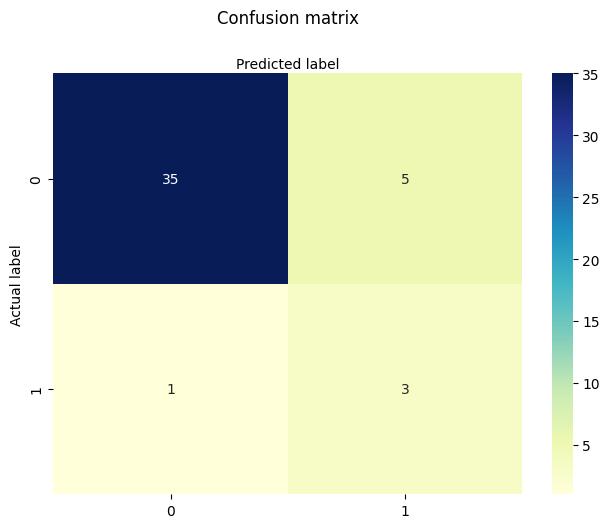

In [672]:
class_names=[0,1] # name  of classes 

fig, ax = plt.subplots() 

tick_marks = np.arange(len(class_names)) 

plt.xticks(tick_marks, class_names) 

plt.yticks(tick_marks, class_names) 

# create heatmap 

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 

ax.xaxis.set_label_position("top") 

plt.tight_layout() 

plt.title('Confusion matrix', y=1.1) 

plt.ylabel('Actual label') 

plt.xlabel('Predicted label')

In [673]:
#this is for S = 1 (predicting susceptibility)
sensitivity = cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0])
specificity = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
print(sensitivity, specificity)

#this is for R = 1 (predicting resistance)
# specificity = cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0])
# sensitivity = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
# print(sensitivity, specificity)

0.75 0.875


In [572]:
random_seed = 144

folds = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)

model_xgb = XGBClassifier()

param_grid = [ 
        {   'n_estimators': [25, 50, 100, 150, 200],
            'subsample': [0.6, 0.7, 0.8, 0.9, 1],
            'max_depth':[2,4,5,6,8],
            'min_child_weight': [0, 0.1, 1, 10],
            'learning_rate':[0.005, 0.01, 0.05, 0.075, 0.1, 0.125, 0.1] } 
    ]

#line, best_XB, cv_results_XB = tune_model(line, model_xgb, "XB", X, Y, param_grid, folds, optimisation_score)


In [573]:
gsvc = GridSearchCV(model_xgb, 
                    param_grid, 
                    cv = folds, 
                    n_jobs=-1,
                    return_train_score=True,
                    scoring = ['recall', 'roc_auc', 'precision'], 
                    refit = 'recall') #, scoring='f1' , scoring = 'recall'

gsvc.fit(X_train,y_train)
gsvc.cv_results_

{'mean_fit_time': array([0.02448268, 0.02719707, 0.02515345, ..., 0.06711917, 0.07141066,
        0.06420045]),
 'std_fit_time': array([0.00169899, 0.0032965 , 0.00245735, ..., 0.00210865, 0.00446822,
        0.00465946]),
 'mean_score_time': array([0.02049699, 0.02259097, 0.02657852, ..., 0.01561418, 0.0164216 ,
        0.01312418]),
 'std_score_time': array([0.00395018, 0.0049723 , 0.00495529, ..., 0.00070156, 0.00099723,
        0.00224325]),
 'param_learning_rate': masked_array(data=[0.005, 0.005, 0.005, ..., 0.1, 0.1, 0.1],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[2, 2, 2, ..., 8, 8, 8],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[0, 0, 0, ..., 10, 10, 10],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?

In [574]:
df = pd.DataFrame(gsvc.cv_results_)
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_learning_rate', 'param_max_depth', 'param_min_child_weight',
       'param_n_estimators', 'param_subsample', 'params', 'split0_test_recall',
       'split1_test_recall', 'split2_test_recall', 'split3_test_recall',
       'split4_test_recall', 'mean_test_recall', 'std_test_recall',
       'rank_test_recall', 'split0_train_recall', 'split1_train_recall',
       'split2_train_recall', 'split3_train_recall', 'split4_train_recall',
       'mean_train_recall', 'std_train_recall', 'split0_test_roc_auc',
       'split1_test_roc_auc', 'split2_test_roc_auc', 'split3_test_roc_auc',
       'split4_test_roc_auc', 'mean_test_roc_auc', 'std_test_roc_auc',
       'rank_test_roc_auc', 'split0_train_roc_auc', 'split1_train_roc_auc',
       'split2_train_roc_auc', 'split3_train_roc_auc', 'split4_train_roc_auc',
       'mean_train_roc_auc', 'std_train_roc_auc', 'split0_test_precision',
       'split1_test_precision'

In [581]:
gsvc.best_estimator_.learning_rate

0.005

In [582]:
xgb =  XGBClassifier(n_estimators = 25, subsample = 0.6, max_depth = 2, min_child_weight = 10, learning_rate = 0.005)

In [583]:
xgb.fit(X_train,y_train) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=25, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [584]:
y_pred = xgb.predict(X_test) 

In [585]:
y_df = pd.DataFrame(y_pred)
y_df.value_counts()

1    44
Name: count, dtype: int64

In [586]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

cnf_matrix 

array([[ 0,  4],
       [ 0, 40]])

Text(0.5, 427.9555555555555, 'Predicted label')

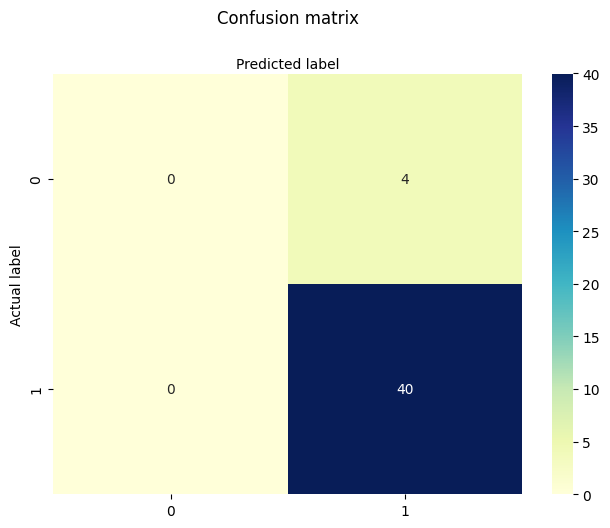

In [587]:
class_names=[0,1] # name  of classes 

fig, ax = plt.subplots() 

tick_marks = np.arange(len(class_names)) 

plt.xticks(tick_marks, class_names) 

plt.yticks(tick_marks, class_names) 

# create heatmap 

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 

ax.xaxis.set_label_position("top") 

plt.tight_layout() 

plt.title('Confusion matrix', y=1.1) 

plt.ylabel('Actual label') 

plt.xlabel('Predicted label')

In [588]:
#this is for S = 1 (predicting susceptibility)
sensitivity = cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0])
specificity = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
print(sensitivity, specificity)

#this is for R = 1 (predicting resistance)
specificity = cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0])
sensitivity = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
print(sensitivity, specificity)

1.0 0.0
0.0 1.0
